### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import ipywidgets as ipw
from numpy.random import randn, rand
from scipy.io import loadmat
import time
import statistics as stat
from functools import wraps

### Runtime

In [3]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper

### Read data

In [35]:
# Note that there are several shapes in the LASA Handwriting dataset

# name_of_dataset = 'Angle'
# name_of_dataset = 'CShape'
# name_of_dataset = 'GShape'
# name_of_dataset = 'JShape'
name_of_dataset = 'Sshape'

dataset = loadmat(name_of_dataset + '.mat')

# Unpack the trajectories and place into x and y used in learning step
num_of_demos = dataset['demos'].shape[1]
size_of_state = dataset['demos'][0, 0][0,0][0].shape[0]
dim_of_function = size_of_state 

x_cell = np.zeros((1, num_of_demos))
y_cell = np.zeros((1, num_of_demos))

In [55]:
# We need an init position for future simulation of learnt system
init_position_of_demos = np.zeros((size_of_state, num_of_demos))

for i in range(0, num_of_demos-1):
    demo_struct = dataset['demos'][0,i][0,0]

    position_dataseries = dataset['demos'][0,i][0,0][0]
    velocity_dataseries = dataset['demos'][0,i][0,0][2] # is at position 3 in .mat file

    x_cell[0, i] = position_dataseries
    y_cell[0, i] = velocity_dataseries

init_position_of_demos[:,i] = position_dataseries[:,0]

print(x_cell)
print(y_cell)

x_train = x_cell
y_train = y_cell

num_of_points = x_train.shape[1]

# Get time info for simulating the learnt system later

time_step = dataset['dt'][0,0] # good

len_of_dataseries = dataset['demos'][0, 0][0,0][0].shape[1]

concatenate = np.concatenate((np.array([[0]]), time_step * np.ones((1, len_of_dataseries - 1))),axis=1) # axis = 1 is to concatenate at the second dimension
time_series = np.cumsum(concatenate) # OK

num_of_timesteps = len_of_dataseries

# Intial starting point for the simulated trajectory using learnt model
init_condition = stat.mean(init_position_of_demos[1]) # Average starting point of all demos

[0.         0.00462223 0.00924447 0.0138667  0.01848894 0.02311117
 0.0277334  0.03235564 0.03697787 0.04160011 0.04622234 0.05084458
 0.05546681 0.06008904 0.06471128 0.06933351 0.07395575 0.07857798
 0.08320021 0.08782245 0.09244468 0.09706692 0.10168915 0.10631138
 0.11093362 0.11555585 0.12017809 0.12480032 0.12942256 0.13404479
 0.13866702 0.14328926 0.14791149 0.15253373 0.15715596 0.16177819
 0.16640043 0.17102266 0.1756449  0.18026713 0.18488936 0.1895116
 0.19413383 0.19875607 0.2033783  0.20800053 0.21262277 0.217245
 0.22186724 0.22648947 0.23111171 0.23573394 0.24035617 0.24497841
 0.24960064 0.25422288 0.25884511 0.26346734 0.26808958 0.27271181
 0.27733405 0.28195628 0.28657851 0.29120075 0.29582298 0.30044522
 0.30506745 0.30968969 0.31431192 0.31893415 0.32355639 0.32817862
 0.33280086 0.33742309 0.34204532 0.34666756 0.35128979 0.35591203
 0.36053426 0.36515649 0.36977873 0.37440096 0.3790232  0.38364543
 0.38826767 0.3928899  0.39751213 0.40213437 0.4067566  0.4113788

#### Plot dataset (state trajectory with velocities as arrows)

NameError: name 'x_train' is not defined

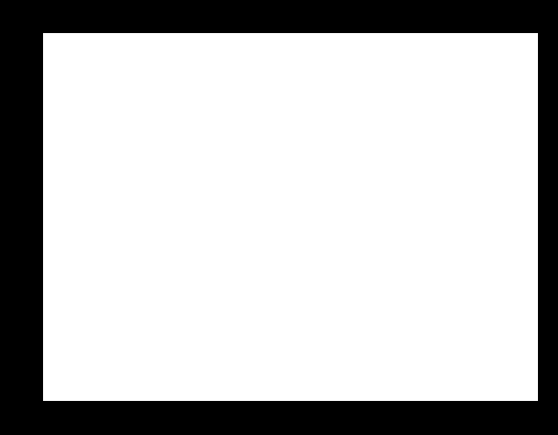

In [56]:
fig_dataset = plt.figure()
plt.style.use('default')
plt.title('Trajectory used in regression problem -' + name_of_dataset)
plt.plot(x_train[0,:], x_train[1,:], y_train[0,:], y_train[1,:])
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(['Trajectory', 'Velocities'])

### From notebook: vector_valued_with_rff

In [ ]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, m):
    psi_vector = np.zeros(m)
    for i in range(m):
        psi_vector[i] = psi(x, w[:, i], b[:,i])
    return np.array(psi_vector)

def capital_psi(x, w, b, m, dim):
    psi = psi_vector(x,w,b,m)
    return np.kron(psi, np.eye(dim))


def phi(x, w, b, n, m, dim):
    phi = np.zeros((dim*n, dim*m))
    for i in range(0, n):
        psi = capital_psi(x[:,i], w, b, m, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

def alpha_approx(x_vector, y, dim, m, lam, n):
    start_time = time()
    phi_ = phi(x_vector, w, b, n, m, dim)
    alpha_inv_part = np.linalg.inv(phi_.T @ phi_ + lam*np.eye(dim*m))
    y_reshaped = np.reshape(y, (-1,1))
    alpha = alpha_inv_part @ (phi_.T @ y_reshaped)
    end_time = time()
    interval = start_time-end_time
    return alpha, "Runtime:", interval

### Random Fourier Features & Regression

In [ ]:
sigma = 5
num_of_samples = 50

w = randn(size_of_state, num_of_samples)/sigma
b = rand(1,num_of_samples)*2*np.pi

# Random Fourier features approx
lambda_ = 0.001 # regularization parameter lamda

alpha_array_rff = alpha_approx(x_train, y_train, dim_of_function, num_of_samples, lambda_, num_of_points)

# Create callable function for learnt dynamics (straight from working note)
def learnt_model(t, x):
    func = capital_psi(x_train[:, i], w, b, num_of_samples, dim_of_function) @ alpha_array_rff
    return func.T

#### Solve diff. equation using learnt model w. solver_ivp

In [57]:
[time_series, data_series] = solve_ivp(learnt_model, time_series, init_condition).y

NameError: name 'learnt_model' is not defined

### Plot simulated trajectory and streamslices for learnt model

In [ ]:
# Get lower and upper bound for plotting from dataset figure

lower_bound_x1 = fig_dataset.axes.x_limit[0]
upper_bound_x1 = fig_dataset.axes.x_limit[1]
lower_bound_x2 = fig_dataset.axes.y_limit[0]
upper_bound_x2 = fig_dataset.axes.y_limit[1]

num_of_points = 17

x1 = np.linspace(lower_bound_x1, upper_bound_x1, num_of_points)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points)

# Base point or starting point for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

# Calculate df/dt for each point
t = 0

u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

# for loop to get the velocity at each point witht the learnt model
for (i,j), value in np.ndenumerate(X1):

    # get velocities at each point with the learnt model
    Y_prime = learnt_model(t, np.array([value, X2[i, j]]))
    u_learnt[i,j] = Y_prime[:,0]
    v_learnt[i,j] = Y_prime[:,1]

#### Combined solution and vector field for learnt model

NameError: name 'data_series' is not defined

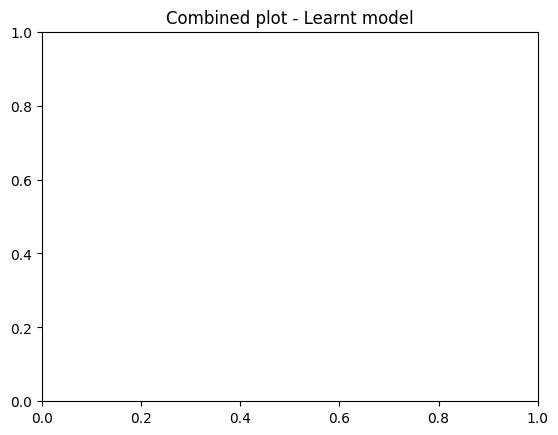

In [ ]:
plt.figure()
plt.style.use('default')
plt.title('Combined plot - Learnt model')
plt.plot(data_series[:, 0], data_series[:, 1], '.', linewidth=1)
plt.streamplot(X1, X2, u_learnt, v_learnt)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(['Trajectory', 'Streamlines'])
plt.xlim([lower_bound_x1, upper_bound_x1])
plt.ylim([lower_bound_x2, upper_bound_x2])